In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from constant import *
from helpers import *

### 1. Data Loading

In [2]:
DATA_DIR = '../res/recipes/'

In [3]:
# Collect all the recipes for all regions
recipes_lst = []
for filename in os.listdir(DATA_DIR):
  if filename.endswith('.txt'):
    recipes_lst += read_region_file(DATA_DIR+filename)

# Create the dataframe with all the recipes
recipes_df = pd.DataFrame(
  recipes_lst, 
  columns= ['subregion', 'recipe_name', 'ingredients_inferred', 'nb_persons', 'ingredients', 'recipe_body']
)

In [4]:
recipes_df.head()

,subregion,recipe_name,ingredients_inferred,nb_persons,ingredients,recipe_body
0,Alsace,LE KUGELHOPF,with,6,0.5 litre de lait\n500 g farine\n250 g beurre\...,Pour 6 personnes : Mettez dans une terrine 1/2...
1,Alsace,LE SCHWOWCBREDEL,with,6,500 g farine\n500 g sucre\n500 g amandes\n500 ...,Pour 6 personnes: Mélanger farine et beurre. R...
2,Alsace,PARFAIT DE FOIE GRAS STRASBOURGEOISE,with,-,1 kg foie gras oiseau\n1 truffe\n1 dl gelée\n1...,"1 kg de foie gras d’Alsace 1er qualité, dénerv..."
3,Alsace,TRUITES DE LA FECHT COLMARIENNE,with,4,4 truites\n8 écrevisses\n4 œufs\n50 g oignons\...,Pour 4 personnes: Prenez 4 belles truites du t...
4,Alsace,LES SCHANKELAS,with,-,375 g sucre\n250 g amandes\n200 g beurre\n250 ...,Ecraser le beurre avec la farine et bien mêler...


### 2. Data Processing

In [5]:
# Create a column for the region
recipes_df['region'] = recipes_df['subregion'].apply(
  lambda subregion: [region for region, subregions in Region2SubRegion.items() if subregion in subregions][0]
)

In [6]:
# Add the list of ingredients in tuple form for each recipe
recipes_df['ingredients_tuple'] = recipes_df.apply(process_ingredients_from_recipe, axis=1)

In [7]:
recipes_ingredients_list = []
recipes_ingredients_category = []

for idx, recipe in recipes_df.iterrows():
  ingredients_list = []
  ingredients_category = []

  for ing_tuple in recipe['ingredients_tuple']:
    ingredients_list.append(ing_tuple[2])
    ingredients_category.append(ing_tuple[3])
  
  recipes_ingredients_list.append(ingredients_list)
  recipes_ingredients_category.append(ingredients_category)

# Column containing the ingredients content for each recipe
recipes_df['ingredients_list'] = recipes_ingredients_list

# Column containing the ingredients category for each recipe
recipes_df['ingredients_category'] = recipes_ingredients_category


In [8]:
recipes_df = recipes_df[[
  'region', 'subregion', 'recipe_name', 'nb_persons', 'ingredients', 'ingredients_tuple', 
  'ingredients_list', 'ingredients_category', 'recipe_body', 'ingredients_inferred'
]]

In [9]:
recipes_df.head()

,region,subregion,recipe_name,nb_persons,ingredients,ingredients_tuple,ingredients_list,ingredients_category,recipe_body,ingredients_inferred
0,"Bourgogne, Champagne, Bresse, Franche-Comté, A...",Alsace,LE KUGELHOPF,6,0.5 litre de lait\n500 g farine\n250 g beurre\...,"{(500, g, farine, Céréale), (1, pincée, sel, E...","[farine, sel, lait, levure de boulanger, œufs,...","[Céréale, Epice, Produit laitier, Champignon, ...",Pour 6 personnes : Mettez dans une terrine 1/2...,with
1,"Bourgogne, Champagne, Bresse, Franche-Comté, A...",Alsace,LE SCHWOWCBREDEL,6,500 g farine\n500 g sucre\n500 g amandes\n500 ...,"{(500, g, farine, Céréale), (30, g, cannelle e...","[farine, cannelle en poudre, sucre, œufs, eau ...","[Céréale, Epice, -, -, -, Fruit, -, Fruit sec]",Pour 6 personnes: Mélanger farine et beurre. R...,with
2,"Bourgogne, Champagne, Bresse, Franche-Comté, A...",Alsace,PARFAIT DE FOIE GRAS STRASBOURGEOISE,-,1 kg foie gras oiseau\n1 truffe\n1 dl gelée\n1...,"{(100, g, beurre, -), (1, dl, gelée, -), (1, k...","[beurre, gelée, foie gras oiseau, truffe]","[-, -, Viande, Champignon]","1 kg de foie gras d’Alsace 1er qualité, dénerv...",with
3,"Bourgogne, Champagne, Bresse, Franche-Comté, A...",Alsace,TRUITES DE LA FECHT COLMARIENNE,4,4 truites\n8 écrevisses\n4 œufs\n50 g oignons\...,"{(-, -, poivre, Epice), (50, g, oignons, -), (...","[poivre, oignons, vin blanc, laurier, thym, lé...","[Epice, -, Alcool, Plante aromatique, Plante a...",Pour 4 personnes: Prenez 4 belles truites du t...,with
4,"Bourgogne, Champagne, Bresse, Franche-Comté, A...",Alsace,LES SCHANKELAS,-,375 g sucre\n250 g amandes\n200 g beurre\n250 ...,"{(200, g, beurre, -), (-, -, fleur d'oranger, ...","[beurre, fleur d'oranger, amandes, œufs, farin...","[-, -, Fruit sec, -, Céréale, Fruit, -, -]",Ecraser le beurre avec la farine et bien mêler...,with


### 3. Data Analysis

In [10]:
# Categories used for the analysis
ingredients_categories = list(Categories.keys())
ingredients_categories.append('-')


#### 3.1 Overall Analysis

##### Frequency of ingredients

In [11]:
ingredients_frequency(recipes_df)

{'beurre': 180,
 'sel': 167,
 'poivre': 146,
 'œufs': 101,
 'oignons': 95,
 'farine': 89,
 'persil': 82,
 'ail': 76,
 'vin blanc': 69,
 'bouquet garni': 46,
 'échalotes': 41,
 'carottes': 37,
 'champignons': 37,
 'laurier': 35,
 'lait': 33,
 "huile d'olive": 32,
 'citron': 31,
 'bouillon': 31,
 'sucre': 30,
 'thym': 28,
 'pommes de terre': 27,
 'vinaigre': 26,
 'estragon': 26,
 'huile': 25,
 'échalote': 24,
 'tomates': 24,
 'lard porc': 22,
 'muscade': 19,
 'vin rouge': 18,
 'truffe': 17,
 'crème fraîche': 17,
 'cerfeuil': 17,
 'jambon porc': 16,
 'épices': 15,
 'moutarde': 14,
 'mie de pain': 14,
 'crème': 14,
 'poulet': 13,
 'petits oignons': 13,
 'foie gras oiseau': 12,
 'crème double': 12,
 'céleri': 11,
 'gruyère': 11,
 'poireaux': 11,
 'eau-de-vie': 11,
 'sucre en poudre': 11,
 'écrevisses': 9,
 'pomme de terre': 9,
 'truffes': 9,
 'lardons porc': 9,
 'chapelure': 8,
 'pain': 8,
 'fines herbes': 8,
 'clou de girofle': 8,
 'gros oignons': 8,
 'piment rouge': 8,
 'clous de girofle'

##### Frequency of ingredient categories

In [12]:
categories_frequency(recipes_df)

{'-': 752,
 'Epice': 424,
 'Plante aromatique': 392,
 'Viande': 322,
 'Légume': 226,
 'Céréale': 147,
 'Alcool': 144,
 'Fruit': 120,
 'Produit laitier': 110,
 'Champignon': 88,
 'Poisson': 76,
 'Fruit de mer': 34,
 'Légumineuse': 21,
 'Fruit sec': 11}

#### 3.2 Analysis per Subregions

##### Frequency of ingredient categories

In [13]:
# Create a frequency matrix (Subregion x Category)
heatmap_subregions_df = pd.DataFrame(0, columns=list(ingredients_categories), index=recipes_df.subregion.unique())

# Go through each recipe
for index, recipe in recipes_df.iterrows():
  # Get the subregion of the recipe
  subregion = heatmap_subregions_df.loc[recipe.subregion]

  # Increase the count of each category present in the recipe for its associated region
  for c in recipe.ingredients_category:
    subregion[c] += 1

In [14]:
heatmap_subregions_df.head()

,Viande,Poisson,Fruit de mer,Alcool,Plante aromatique,Epice,Produit laitier,Légume,Fruit,Céréale,Légumineuse,Fruit sec,Champignon,-
Alsace,5,1,1,2,3,3,4,3,4,6,0,3,2,30
Limousin,14,0,0,2,10,15,5,6,0,6,0,0,2,23
Bretagne,9,12,3,5,28,32,8,13,8,9,3,0,1,41
Provence,4,9,1,2,28,20,5,23,16,7,0,0,6,23
Anjou,13,3,0,8,7,21,5,6,3,5,0,0,5,24


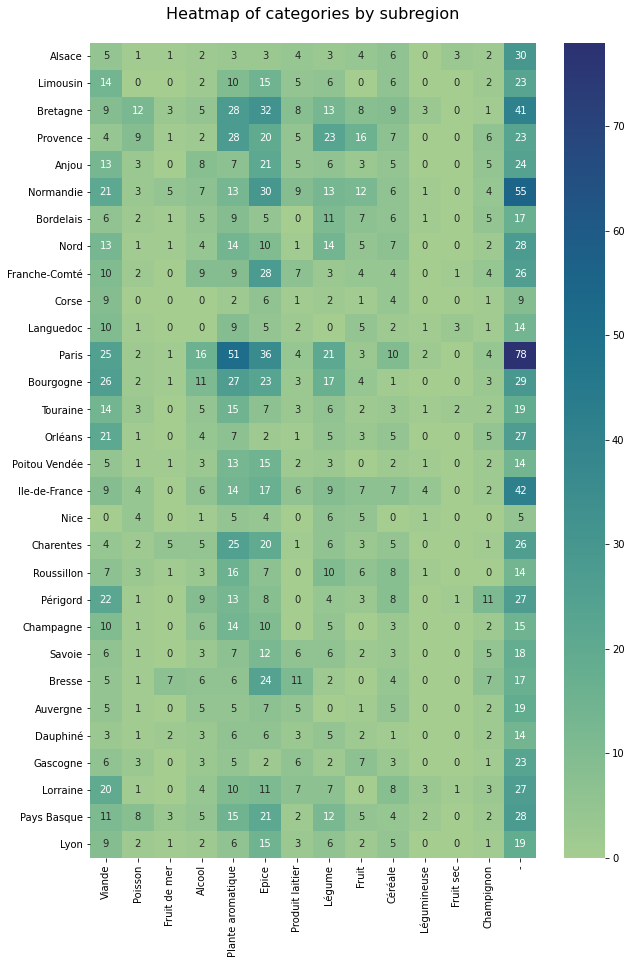

In [15]:
plt.figure(figsize=(10, 15))
plt.title('Heatmap of categories by subregion\n', fontsize=16)
sns.heatmap(heatmap_subregions_df, cmap="crest", annot=True, fmt="d")
plt.show()

In [16]:
# Compute a matrix of co-occurences (within subregions) of ingredients categories
co_occurences = heatmap_subregions_df.T.dot(heatmap_subregions_df)
np.fill_diagonal(co_occurences.values, 0)

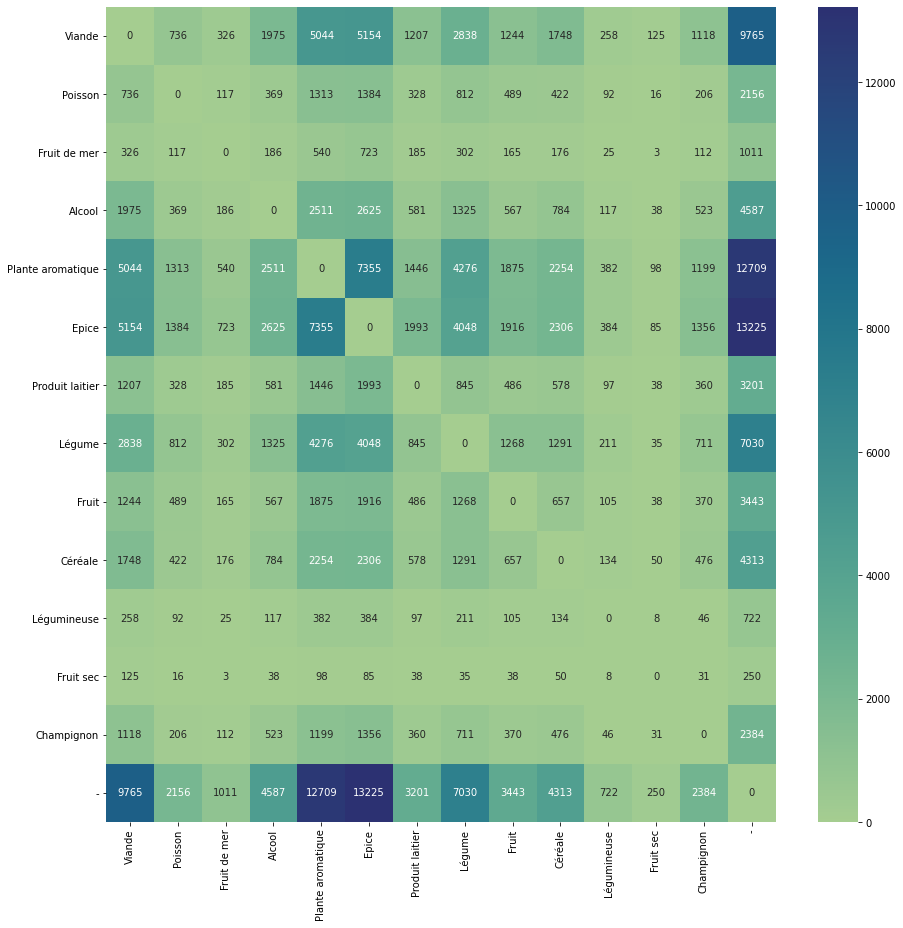

In [17]:
plt.figure(figsize=(15, 15))
sns.heatmap(co_occurences, cmap="crest", annot=True, fmt=".8g")
plt.show()

#### 3.3 Analysis per Region

##### Frequency of ingredient categories

In [18]:
# Create a frequency matrix (Region x Category)
heatmap_regions_df = pd.DataFrame(0, columns=list(ingredients_categories), index=recipes_df.region.unique())

# Go through each recipe
for index, recipe in recipes_df.iterrows():
  # Get the subregion of the recipe
  region = heatmap_regions_df.loc[recipe.region]

  # Increase the count of each category present in the recipe for its associated region
  for c in recipe.ingredients_category:
    region[c] += 1

In [19]:
heatmap_regions_df

,Viande,Poisson,Fruit de mer,Alcool,Plante aromatique,Epice,Produit laitier,Légume,Fruit,Céréale,Légumineuse,Fruit sec,Champignon,-
"Bourgogne, Champagne, Bresse, Franche-Comté, Alsace, Lorraine",76,8,9,38,69,99,32,37,12,26,3,5,21,144
Sud-Est & Méditérannée,50,18,4,18,69,85,28,54,29,31,1,0,19,130
Pays de l’Ouest,31,18,9,21,73,88,16,28,14,21,4,0,9,105
Nord & Normandie,34,4,6,11,27,40,10,27,17,13,1,0,6,83
Sud-Ouest & Pyrénées,62,18,5,25,67,48,10,39,33,31,5,4,20,123
"Paris, Ile-de-France, Val de Loire",69,10,1,31,87,62,14,41,15,25,7,2,13,166


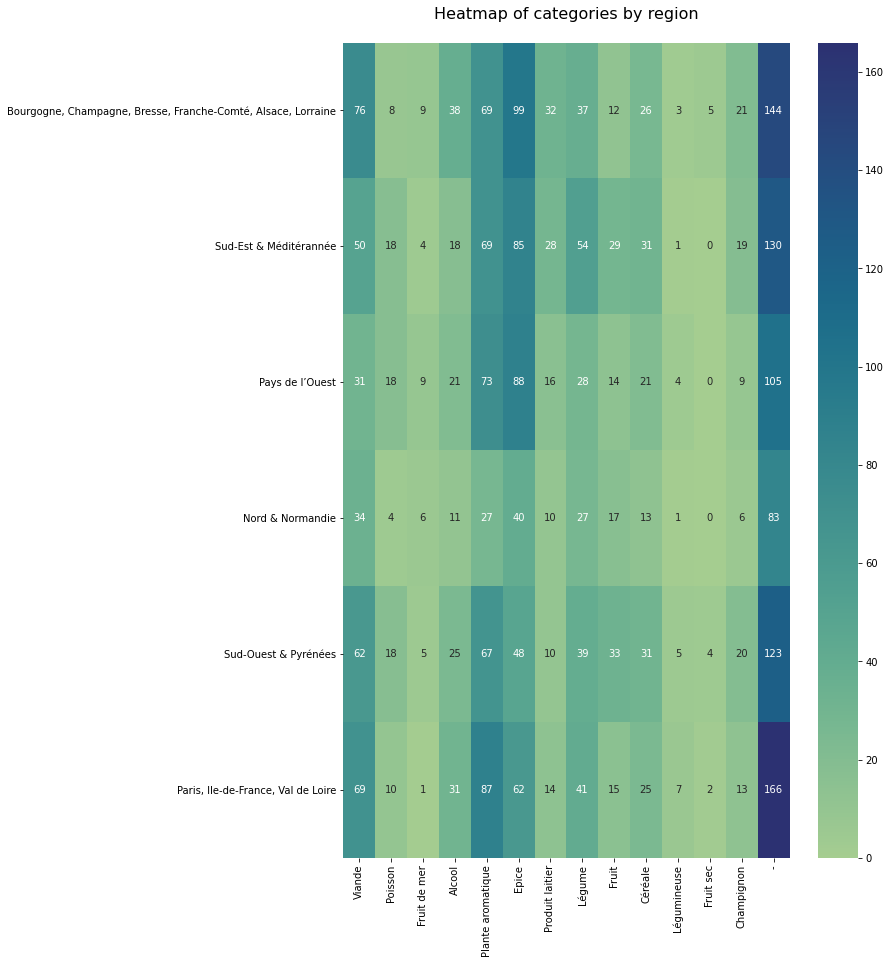

In [20]:
plt.figure(figsize=(10, 15))
plt.title('Heatmap of categories by region\n', fontsize=16)
sns.heatmap(heatmap_regions_df, cmap="crest", annot=True, fmt="d")
plt.show()